In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
beta_min = 0.0001
beta_max = 0.2
n_steps = 1000
beta = torch.linspace(beta_min, beta_max, n_steps)
alpha = (1 - beta).to(device)
alpha_bar = alpha.cumprod(dim=0).to(device)
sigma = beta.sqrt().to(device)

In [3]:
def noise_image(x):
    device = x.device
    noise = torch.randn_like(x).to(device)
    t = torch.randint(0, 1000, (len(x),), dtype=torch.long, device=device)
    ab_t = alpha_bar[t].reshape(-1, 1, 1, 1) 
    xt = (ab_t.sqrt()*x) + ((1 - ab_t).sqrt()*noise)
    return xt, t, noise

In [4]:
@torch.inference_mode()
def ddpm_sample(model, sz, c):
    xt = torch.randn(sz).to(device)
    c = c.to(device)
    preds = []
    for i in reversed(range(n_steps)):
        t = torch.full((xt.shape[0], ), i, dtype=torch.long, device=device)
        pred_noise = model(xt, t, c)
        a_t = alpha[t][:, None, None, None]
        ab_t = alpha_bar[t][:, None, None, None]
        s_t = sigma[t][:, None, None, None]
        z = (torch.randn_like(xt) if i > 0 else torch.zeros_like(xt)).to(device)
        xt_1 = (1/a_t.sqrt())*(xt - (((1-a_t)/(1-ab_t).sqrt())*pred_noise)) + (s_t*z)
        xt = xt_1
        preds.append(xt)
    return xt, preds

In [5]:
import torch
from torch import nn
from torchvision import transforms
from pathlib import Path

from dataset import *
from data_preprocessing import *
from utils import *
from diffusers.models import AutoencoderKL
from unet import *
from attention import *
from time_embedding import *
from ddpm import *

In [6]:
batch_size = 20
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
# unet = UNET(n_classes=2, in_channels=4, out_channels=4, channels=(128, 256, 512, 768), attn_channs=16).to(device)
unet = UNET(n_classes=2, in_channels=4, out_channels=4, channels=(32,64,128,256)).to(device)

In [4]:
torch.cuda.empty_cache()

In [8]:
ddpm = DDPM(0.0001, 0.02, 1000, device)

In [8]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").to(device).requires_grad_(False)


In [9]:
train_data_folder = "./data/256/"
train_latent_folder = Path("./data/latents256/")
test_data_folder = "./data/256test/"
test_latent_folder = Path("./data/latents256test/")


In [ ]:
# train_data_folder = "./data/Linnaeus 5/256x256/train"
# train_latent_folder = Path("./data/Linnaeus 5/32x32/train")
# test_data_folder = "./data/Linnaeus 5/256x256/test"
# test_latent_folder = Path("./data/Linnaeus 5/32x32/test/")

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Conv2d): nn.init.kaiming_normal_(m.weight, a=0.1)
unet.apply(init_weights);

In [ ]:
transform = transforms.Compose([
                transforms.ToTensor(), 
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                transforms.Lambda(lambda x: x.float())
            ])

In [ ]:
data_to_latents(model=vae, 
                  data_folder=train_data_folder, 
                  latent_folder=train_latent_folder, 
                  transform=transform, 
                  batch_size=5, 
                  shuffle=True
               )

In [ ]:
data_to_latents(model=vae, 
                  data_folder=test_data_folder, 
                  latent_folder=test_latent_folder, 
                  transform=transform, 
                  batch_size=5, 
                  shuffle=False
               )

In [ ]:
latent_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[-1.2638,  0.7728,  0.6195, -0.9007], std=[6.1378, 7.1625, 4.4116, 5.5606]),
                # transforms.Lambda(lambda x: x.float())
            ])


In [10]:
train_latent_dl = latent_dataloader(latent_folder=train_latent_folder, 
                                    latent_transform=None, 
                                    batch_size=20, 
                                    shuffle=True
                                )

test_latent_dl = latent_dataloader(latent_folder=test_latent_folder, 
                                    latent_transform=None, 
                                    batch_size=5, 
                                    shuffle=False
                                )

torch.Size([20, 4, 32, 32])


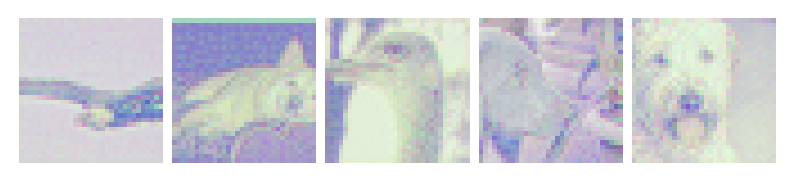

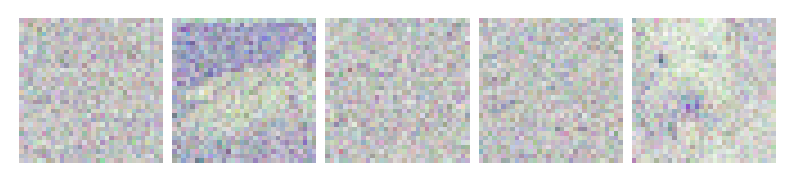

In [14]:
for X, y in train_latent_dl:
    X, y = X.to(device), y.to(device)
    print(X.shape)
#     print(X)
#     print(y)
#     print(X.mean((0, 2, 3)))
#     print(X.std((0, 2, 3)))
    show_images_grid(X)
    xt, t, noise = noise_image(X)
    # pred = unet(xt, t, y)
    show_images_grid(xt)
    break

In [12]:
for X, y in train_latent_dl:
    X, y = X.to(device), y.to(device)
    print(X.shape)
    print(y.shape)

torch.Size([20, 4, 32, 32])
torch.Size([20])
torch.Size([20, 4, 32, 32])
torch.Size([20])
torch.Size([20, 4, 32, 32])
torch.Size([20])
torch.Size([20, 4, 32, 32])
torch.Size([20])
torch.Size([20, 4, 32, 32])
torch.Size([20])
torch.Size([20, 4, 32, 32])
torch.Size([20])
torch.Size([20, 4, 32, 32])
torch.Size([20])
torch.Size([20, 4, 32, 32])
torch.Size([20])
torch.Size([20, 4, 32, 32])
torch.Size([20])
torch.Size([20, 4, 32, 32])
torch.Size([20])


In [11]:
lr = 1e-3
epochs = 300
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=lr)
schedular = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=epochs*len(train_latent_dl))

In [12]:
from IPython.display import display
from tqdm.notebook import trange

train_losses = []
test_losses = []

def train(model, epochs=None):
    model.to(device)
    progress_bar = trange(epochs, desc="Progress")
    display(progress_bar)
    for epoch in progress_bar:
        model.train()
        total_loss = 0
        for X, y in train_latent_dl:
            X, y = X.to(device), y.to(device)
            xt, t, noise = noise_image(X)
            pred = model(xt, t, y)
            loss = loss_fn(pred, noise)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        schedular.step()
        current_epoch = epoch+1

        model.eval()
        with torch.no_grad():
            total_val_loss = 0
            for val_X, val_y in test_latent_dl:
                val_X, val_y = val_X.to(device), val_y.to(device)
                val_xt, val_t, val_noise = noise_image(val_X)
                val_pred = model(val_xt, val_t, val_y)
                val_loss = loss_fn(val_pred, val_noise)
                total_val_loss += val_loss.item()

        total_loss /= len(train_latent_dl)
        total_val_loss /= len(test_latent_dl)
        train_losses.append(total_loss)
        test_losses.append(total_val_loss)
        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"./Saved Models/unet_{current_epoch}.pth")
        print(f"Epoch: {current_epoch} - Loss: {total_loss} | Val Loss: {total_val_loss}")

In [13]:
train(unet, epochs=epochs)

Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1 - Loss: 1.0919263243675232 | Val Loss: 0.9987098500132561
Epoch: 2 - Loss: 1.0553529739379883 | Val Loss: 0.9947087317705154
Epoch: 3 - Loss: 1.0205389499664306 | Val Loss: 0.9966008588671684
Epoch: 4 - Loss: 0.9984997153282166 | Val Loss: 0.9779921844601631
Epoch: 5 - Loss: 0.9783146440982818 | Val Loss: 0.9515188038349152
Epoch: 6 - Loss: 0.9565954089164734 | Val Loss: 0.9697158336639404
Epoch: 7 - Loss: 0.9286045253276825 | Val Loss: 0.9279560297727585
Epoch: 8 - Loss: 0.9084106802940368 | Val Loss: 0.9039981737732887
Epoch: 9 - Loss: 0.8897341966629029 | Val Loss: 0.9007971435785294
Epoch: 10 - Loss: 0.8651586055755616 | Val Loss: 0.8623977601528168
Epoch: 11 - Loss: 0.8529195487499237 | Val Loss: 0.8470616117119789
Epoch: 12 - Loss: 0.8168978750705719 | Val Loss: 0.7881145849823952
Epoch: 13 - Loss: 0.797253555059433 | Val Loss: 0.8154687285423279
Epoch: 14 - Loss: 0.788989531993866 | Val Loss: 0.8554254099726677
Epoch: 15 - Loss: 0.7485550880432129 | Val Loss: 0.81121824

In [15]:
torch.save(unet.state_dict(), "./Saved Models/unet_300.pth")

In [16]:
def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

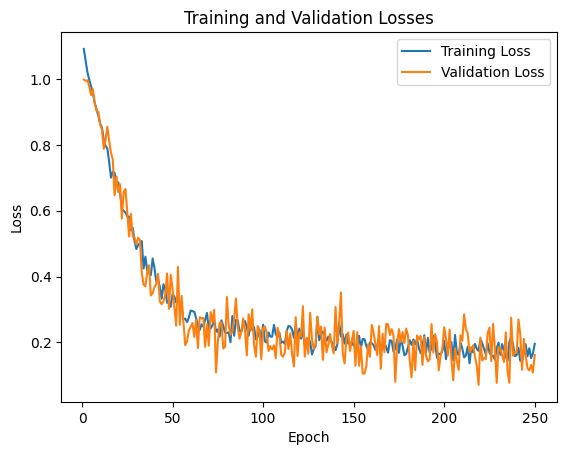

In [18]:
plot_losses(train_losses[:250], test_losses[:250])

In [ ]:
# unet.load_state_dict(torch.load("./Saved Models/unet_81.pth"))

In [114]:
@torch.inference_mode()
def ddpm_sample(model, sz, c):
    xt = torch.randn(sz).to(device)
    c = torch.full((xt.shape[0],), c).to(device)
    preds = []
    for i in reversed(range(n_steps)):
        t = torch.full((xt.shape[0], ), i, dtype=torch.long, device=device)
        pred_noise = model(xt, t, c)
        a_t = alpha[t][:, None, None, None]
        ab_t = alpha_bar[t][:, None, None, None]
        s_t = sigma[t][:, None, None, None]
        z = (torch.randn_like(xt) if i > 0 else torch.zeros_like(xt)).to(device)
        xt_1 = (1/a_t.sqrt())*(xt - (((1-a_t)/(1-ab_t).sqrt())*pred_noise)) + (s_t*z)
        preds.append(xt_1)
        xt = xt_1
    x0 = xt
    return x0, preds

In [115]:
bird_sample = ddpm_sample(unet, (5, 4, 32, 32), torch.tensor(0))

In [116]:
xt, preds = bird_sample

In [117]:
xt.shape, preds[0].shape

(torch.Size([5, 4, 32, 32]), torch.Size([5, 4, 32, 32]))

In [20]:
torch.cuda.empty_cache()

In [ ]:
img = vae.decode(xt)
show_images_grid(img["sample"])

In [ ]:
img = vae.decode(noise)
show_images_grid(img["sample"])